In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

/mnt2/wisniewski/nazanin/NeuralLMs/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

tokenizer = AutoTokenizer.from_pretrained('google/multiberts-seed_0')
model = AutoModelForMaskedLM.from_pretrained('google/multiberts-seed_0').to(device)

cuda


/mnt2/wisniewski/nazanin/NeuralLMs/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [9]:
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [10]:
sentence = 'the authors [MASK]'
encoded_input = tokenizer(sentence, return_tensors="pt")
tokens = tokenizer.tokenize(sentence, add_special_tokens=True)
tokens

['[CLS]', 'the', 'authors', '[MASK]', '[SEP]']

In [11]:
output = model(**encoded_input, output_attentions=True, output_hidden_states=True)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [12]:
for key in output.keys():
    print(key)

logits
hidden_states
attentions


## View attentions matrices

The self-attention $a_{j \rightarrow i}$ describes how important is the $j$-th token to build the representation of the $i$-th token. We now that $a_{j \leftarrow j}$ is probability distribution

In [13]:
attentions = output.attentions
print(len(attentions))  # The encoder attention is a list of 12 tensors, one for each `BertEncoderLayer` in the model.
print(attentions[-1].shape) # Each attention is a `[batch_size ✕ n_heads ✕ input_sequence_length ✕ input_sequence_length]`.

12
torch.Size([1, 12, 5, 5])


In [14]:
# the first attention head on the last layer
first_self_attention_head = attentions[-1][0, -1, :].detach()
first_self_attention_head.sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def attention_matrices(attentions, tokens):
    n_heads = attentions.shape[1]
    fig,ax = plt.subplots(n_heads, 1, figsize=(6, n_heads * 4), sharex=True)

    for layer in range(n_heads):
        plt.sca(ax[layer])
        self_attention = attentions[0, layer, :].detach() #.sum(axis=0)#.max(axis=0)[0]

        plot = sns.heatmap(pd.DataFrame(data=self_attention.numpy(),
                                index=tokens,
                                columns=tokens), cmap="crest")
        plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
        plot.set_xlabel("source")
        plot.set_ylabel("cible")

# attention_matrices(attentions[-1], tokens)

In [19]:
# the attention weight of the second_last token (-2) in the first attention head (0) of the last layer (-1), with respect to the third token (2).
attentions[-1][0][-2][2]

tensor([0.0522, 0.0968, 0.0202, 0.0584, 0.7724], grad_fn=<SelectBackward0>)

## View hidden states

In [18]:
hidden_states = output.hidden_states
print(len(hidden_states))   # 13
print(hidden_states[0].shape)  # Each hidden_state is a `[batch_size ✕ input_sequence_length ✕ hidden_size=768]`.
hidden_states[0]

13
torch.Size([1, 5, 768])


tensor([[[ 0.6036,  0.7125, -0.2618,  ..., -0.1570, -0.4211,  2.0076],
         [ 0.3992, -0.4810, -0.6889,  ..., -0.8744,  0.6597,  0.9523],
         [ 0.4942, -0.0996,  0.5584,  ..., -1.2578,  0.4625, -0.8023],
         [ 0.1734, -0.1455,  0.0244,  ..., -0.0583,  0.1179, -0.4075],
         [-0.0659,  0.5398, -0.1937,  ...,  0.1141, -0.0277,  0.9439]]],
       grad_fn=<NativeLayerNormBackward0>)

In [38]:
# the first hidden state on the last layer
first_hidden_state_head = hidden_states[-1][0, :].detach()
first_hidden_state_head.shape

torch.Size([5, 768])

---

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def attention_matrices(attentions, sequence):
    n_heads = attentions.shape[0]
    seq_tokens = tokenizer.tokenize(sequence)
    seq_len = len(seq_tokens)
    fig,ax = plt.subplots(n_heads, 1, figsize=(seq_len//2, n_heads * seq_len//4))

    for layer in range(n_heads):
        plt.sca(ax[layer])
        # Remove padding tokens from attention matrix
        self_attention = attentions[layer, :seq_len, :seq_len]

        plot = sns.heatmap(pd.DataFrame(data=self_attention,
                                index=seq_tokens,
                                columns=seq_tokens), cmap="crest")
        plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
        plot.set_xlabel("source")
        plot.set_ylabel("cible")

In [47]:
import pandas as pd
import gzip
import pickle

with gzip.open('../results/toy_outputs.pickle.gz', 'rb') as f:
    model_outputs = pickle.load(f)

df = pd.DataFrame(model_outputs)
df

,step,sequence,1st_layer_attentions,last_layer_attentions,1st_layer_hidden_states,last_layer_hidden_states
0,0,"[CLS] robert boulter is an english film, telev...","[[[0.02327899, 0.02480521, 0.031224396, 0.0311...","[[[0.029735494, 0.034094106, 0.021444628, 0.03...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.3598614, -0.042857237, 0.15685861, -0.7082..."
1,0,[CLS] this was followed by a starring role in ...,"[[[0.017836679, 0.019340424, 0.023151048, 0.01...","[[[0.023836968, 0.023550244, 0.019433707, 0.02...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.6139754, -0.073552735, 0.08336285, -0.7624..."
2,0,"[CLS] in 2004 boulter landed [MASK] role as "" ...","[[[0.010256435, 0.011427815, 0.014662177, 0.01...","[[[0.014177418, 0.015155252, 0.008353272, 0.01...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.4764472, 0.04880204, 0.08530922, -0.782381..."
3,0,[CLS] he was directed by john tiffany and star...,"[[[0.013886626, 0.019140925, 0.018024094, 0.01...","[[[0.019571166, 0.019335583, 0.015742594, 0.01...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.4884081, -0.1105504, -0.010474011, -0.7558..."
4,0,[CLS] he appeared on [MASK] 2006 episode of th...,"[[[0.016280685, 0.022440828, 0.032530718, 0.02...","[[[0.021837415, 0.02184702, 0.017181467, 0.014...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.5991213, -0.12704895, 0.18070886, -0.75066..."
...,...,...,...,...,...,...
151,0,[CLS] in 2000 boulter had a guest @ - @ starri...,"[[[0.01137226, 0.012671074, 0.0132876905, 0.01...","[[[0.015632676, 0.01656188, 0.0152817555, 0.01...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.5018986, 0.10444295, 0.096092865, -0.82490..."
152,0,"[CLS] boulter starred as "" darren "", in the 20...","[[[0.018266851, 0.023773517, 0.028882947, 0.02...","[[[0.024868477, 0.02187645, 0.023646845, 0.020...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.3820622, 0.027590362, 0.013813585, -0.6880..."
153,0,[CLS] he [MASK] directed by john tiffany and s...,"[[[0.008090746, 0.011152049, 0.009900559, 0.00...","[[[0.011527445, 0.011310601, 0.0072329515, 0.0...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.5351449, 0.0016971946, 0.052630313, -0.777..."
154,0,[CLS] the play [MASK] part of a series which f...,"[[[0.009908679, 0.011119091, 0.015843008, 0.01...","[[[0.013783683, 0.011028799, 0.00785201, 0.009...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.573059, -0.0017381294, 0.06955533, -0.7687..."


In [48]:
first_row = df.iloc[0]
first_row['sequence']

'[CLS] robert boulter is an english film, television and theatre actor. [SEP] he had [MASK] guest @ - @ starring role on the television series the bill in 2000. [SEP]'

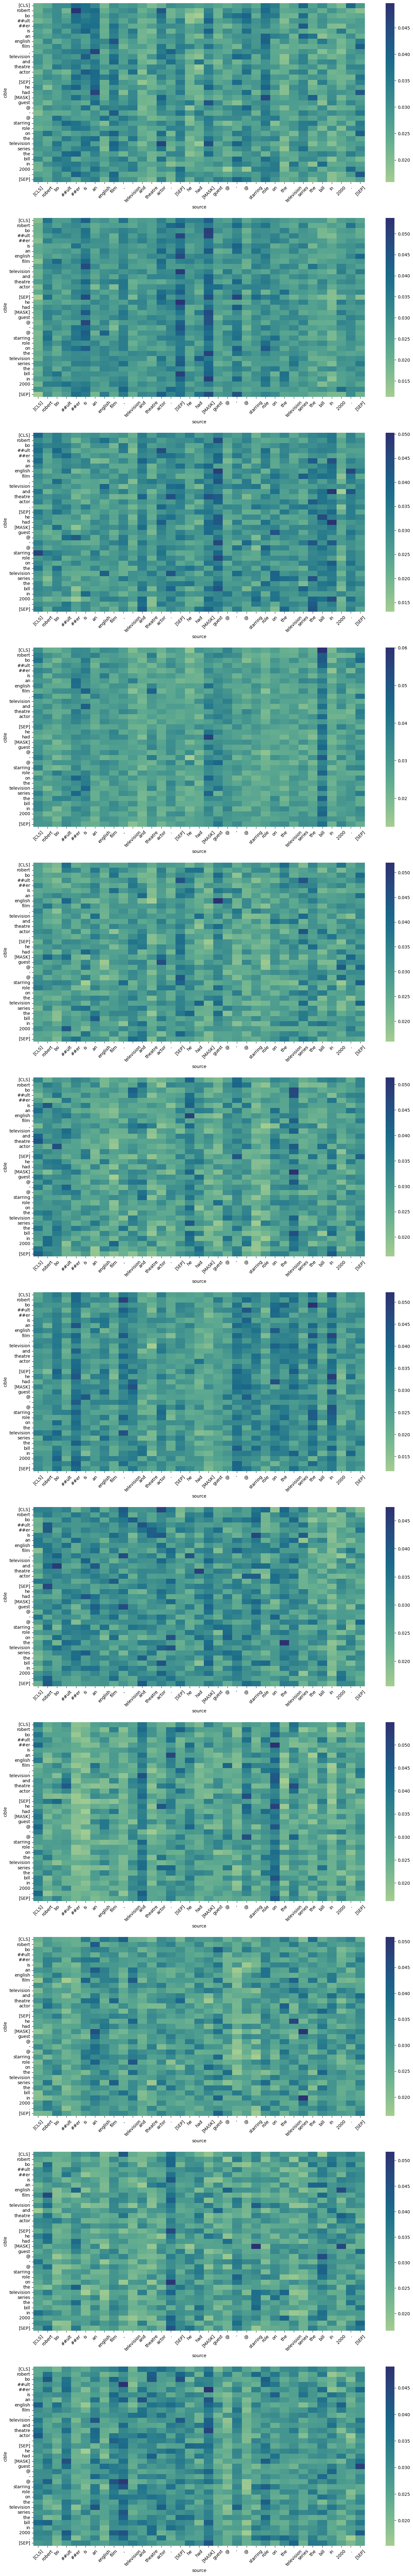

In [49]:
attention_matrices(first_row['1st_layer_attentions'], first_row['sequence'])

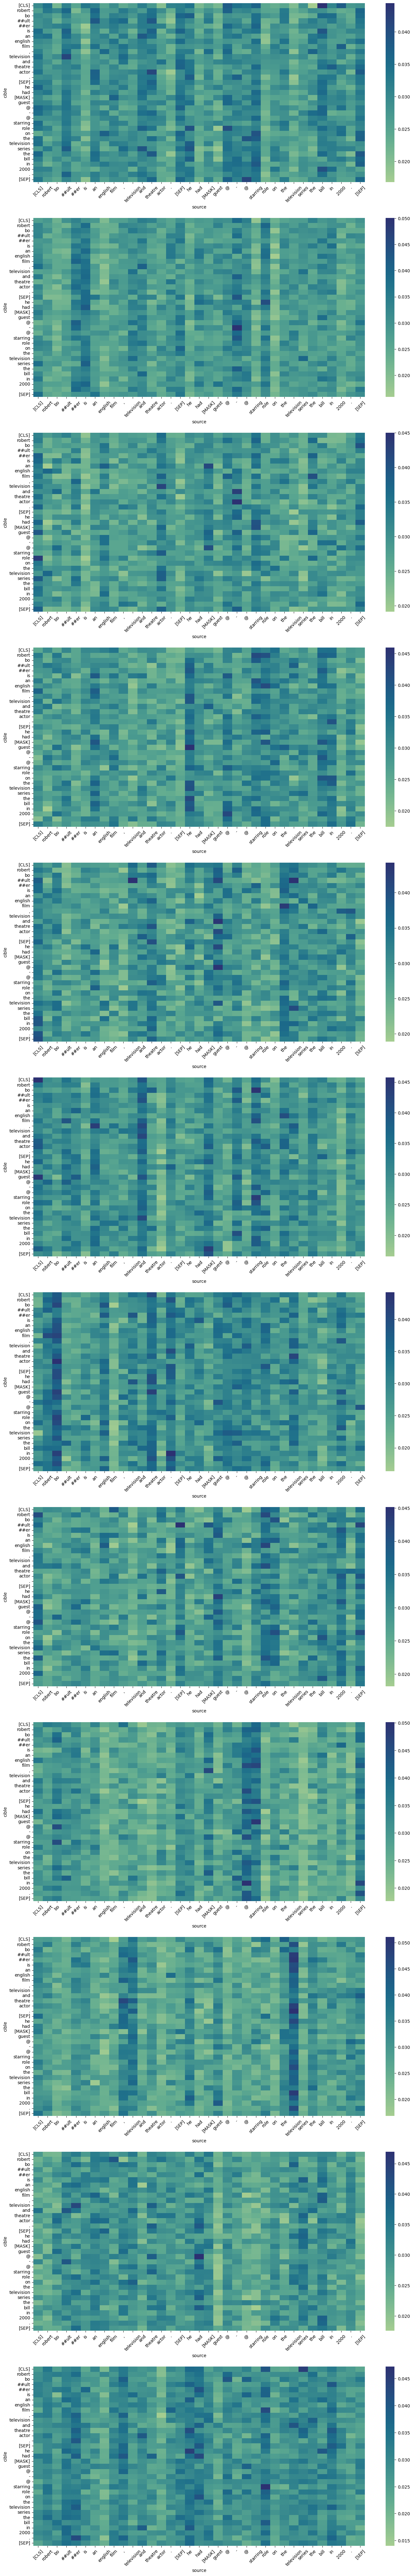

In [51]:
attention_matrices(first_row['last_layer_attentions'], first_row['sequence'])

In [50]:
with gzip.open('../results/att_hs.pickle.gz', 'rb') as f:
    full_att_hs = pickle.load(f)

full_att_hs = pd.DataFrame(full_att_hs)
full_att_hs

,step,sequence,1st_layer_attentions,last_layer_attentions,1st_layer_hidden_states,last_layer_hidden_states
0,0,"[CLS] he recorded his 1, 500th career strikeou...","[[[0.017398378, 0.023981424, 0.021187717, 0.01...","[[[0.025136538, 0.025306404, 0.017549997, 0.02...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.5384157, -0.1203876, 0.071252055, -0.66413..."
1,0,[CLS] he set an mlb record with six consecutiv...,"[[[0.01307743, 0.018025553, 0.016914893, 0.017...","[[[0.019285787, 0.01892818, 0.013205525, 0.016...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.6991924, -0.044185735, 0.020478426, -0.827..."
2,0,[CLS] both these writers showed the influence ...,"[[[0.019647352, 0.025076304, 0.03036573, 0.017...","[[[0.027253345, 0.024483113, 0.019293688, 0.02...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.5160885, 0.081190996, -0.04563508, -0.8477..."
3,0,[CLS] the center attack called for the nk 9th ...,"[[[0.010192903, 0.011438036, 0.018011197, 0.01...","[[[0.014603625, 0.011522314, 0.013010549, 0.00...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.5484983, -0.0014289567, 0.032761034, -0.77..."
4,0,[CLS] the massive north korean attack had made...,"[[[0.008017124, 0.008996471, 0.010304387, 0.00...","[[[0.011409899, 0.009123397, 0.007534239, 0.01...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.639793, -0.023617499, -0.041472957, -0.736..."
...,...,...,...,...,...,...
513,0,[CLS] n / a = round not applicable for the eve...,"[[[0.009946425, 0.0104758125, 0.012128267, 0.0...","[[[0.013028426, 0.013660692, 0.009401906, 0.01...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.5050141, -0.016240194, 0.113178134, -0.701..."
514,0,[CLS] the work is regarded as one of the great...,"[[[0.012552479, 0.014085848, 0.016524704, 0.01...","[[[0.017035987, 0.013674738, 0.015553575, 0.01...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.5820531, -0.08971485, 0.0794446, -0.647679..."
515,0,[CLS] it assigned the copyright to steinberg a...,"[[[0.012952452, 0.016601779, 0.015225532, 0.01...","[[[0.017605213, 0.018387895, 0.013001063, 0.01...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.5090667, -0.049495157, 0.051280934, -0.768..."
516,0,"[CLS] ( s. d. n. y. 1987 ), which held that co...","[[[0.0097761955, 0.011749771, 0.014950203, 0.0...","[[[0.013597851, 0.011930471, 0.009519243, 0.01...","[[1.8502768, -0.34961814, -0.057434723, -0.016...","[[1.4091665, -0.010864105, 0.19474928, -0.7082..."
